## Práctica 1
### Elizaveta Gilyarovskaya
### Parte III: Umbralización y Componentes Conexas

In [1]:
from PIL import Image
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors


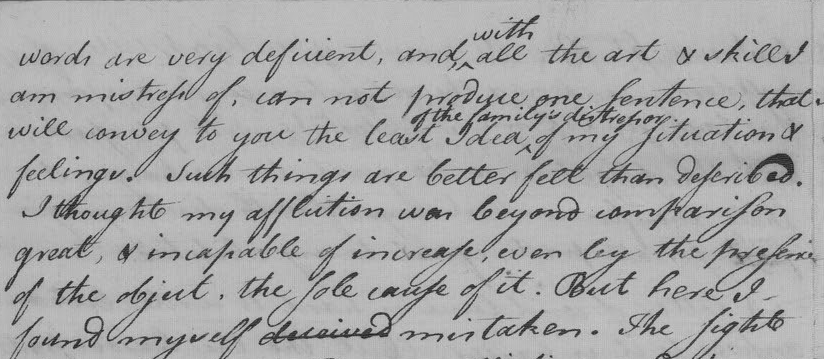

In [2]:
imagenes = [i for i in os.listdir() if i[-3::]== 'png']
carta = Image.open(imagenes[7])
# Convertimos la imagen RGB a otro espacio de color donde tengamos en un plano la “luminancia”, como LAB.
# Asi solo utilizaremos la componente de luminaria, en este caso L.
if carta.mode != "L":
    carta = carta.convert("L")
    
im = np.array(carta)
Image.fromarray(im)

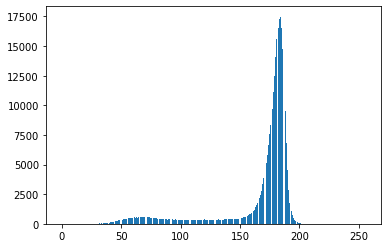

In [3]:
h = carta.histogram()
plt.figure()
plt.bar(range(0,256),h)
plt.show()

In [4]:
%%time
def Otsu(im:np.ndarray):
    f = np.array([np.count_nonzero(im == i) for i in range(256)])
    probs = f / im.size #vectores de probabilidades de cada nivel de gris
    disp = []
    for t in range(0,255):
        p0 = np.sum(probs[0:t])#es la cantidad relativa de píxeles por debajo del umbral
        p1 = 1 - p0
        if p0>0 and p1>0:
            v0 = np.var(im[im<t])
            v1 = np.var(im[im>=t])
            d = p0*v0+p1*v1
            disp.append(d)
        else:
            disp.append(float('inf'))
    t =  np.argmin(disp)
    return t

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 4.77 µs


132


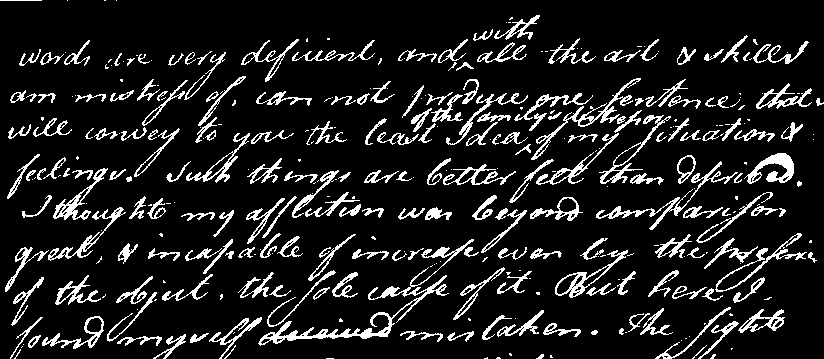

In [5]:
t = Otsu(im)
print(t)
mask = np.zeros(im.shape)
mask[im<t] = 255
mask = np.uint8(mask)
Image.fromarray(mask)

Nos da el valor de 132, que fijándonos en el histograma de la imágen realmente se ve a simple vista que es, efectivamente, el umbral que separa el histograma en dos partes minimazando la dispersión poblacional relativa ( a población de pixel que hay) que tiene cada una de las partes.

d = P<sub>0</sub>*V<sub>0</sub> + P<sub>1</sub>*V<sub>1</sub>

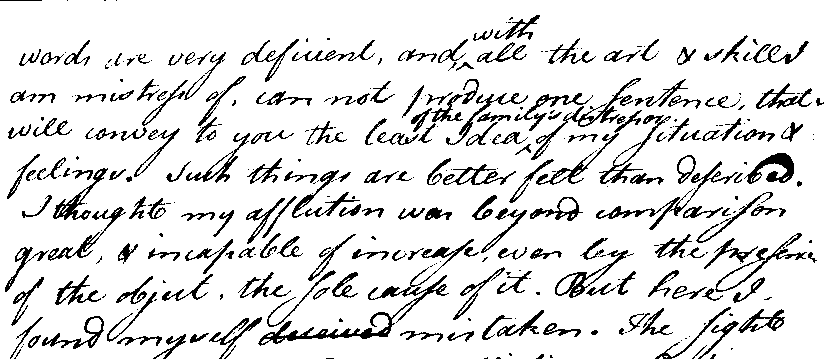

In [6]:
# Para verlo en positivo
mask = 255-mask
Image.fromarray(mask)

Ahora pasamos a hacer otsu adaptativo, para eso abrimos la misma imágen pero con manchas que dificultan el proceso. Por ello habrá que implementar otsu local con ayuda de ventanas emergentes...

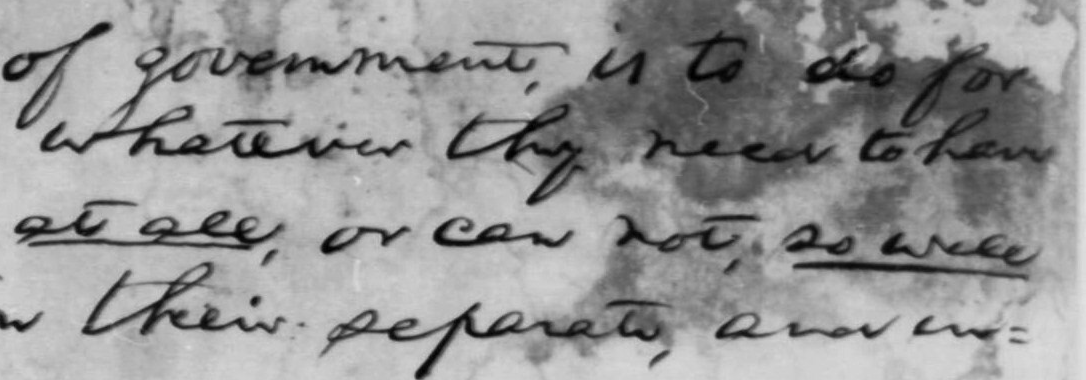

In [7]:
carta2 = Image.open(imagenes[8])
if carta2.mode != "L":
    carta2 = carta2.convert("L")
    
im2 = np.array(carta2)
Image.fromarray(im2)

from skimage.filters import threshold_otsu, threshold_local
global_thresh = threshold_otsu(im2)
block_size = 0.2
binary_adaptive = threshold_local(im2, block_size, offset=10)
Image.fromarray(np.uint8(binary_adaptive))

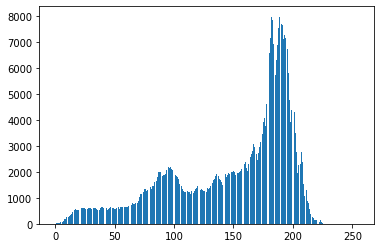

In [8]:
h = carta2.histogram()
plt.figure()
plt.bar(range(0,256),h)
plt.show()

Para **agilizar el tiempo de cómputo**  en lugar de utilizar en Otsu Adaptativo mi función de OTSU, utilizaré la **versión vectorizada de OTSU de skimage** que voy a importar directamente de su librería. Su código fuente es el siguiente:

#### (Utilizar mi función de Otsu o la de skimage da el mismo resultado, solo lo hago para agilizar la ejecución)

In [9]:
from skimage.filters import threshold_otsu 

def Otsu_Adap(im,  window_width=60, window_height=60, overlap=10):
    
    def include_final_range(i, f, overlap=1): 
        #fuerza a que el rango vaya hasta el final para que no se formen bordes
        l = list(range(i, f, overlap))
        if l[-1] != f:
            l.append(f)
        return l

    Mask = np.zeros(im.shape)
    Count = np.zeros(im.shape)
    for i in include_final_range(window_width, im.shape[0], overlap):
        for j in include_final_range(window_height, im.shape[1], overlap):
            # Encontramos el umbral otsu para la ventana emergente
            submatrix = im[i-window_width:i, j-window_height:j]
            t = threshold_otsu(submatrix) #utilizo otsu optimizado de skimage
            #Guardamos los índices de pixeles de la ventana menores que el umbral
            ind0, ind1 = np.asarray(submatrix<t).nonzero()
            ind0 += (i-window_width)
            ind1 += (j-window_height)
            Mask[ind0, ind1] +=1
            Count[i-window_width:i,j-window_height:j] += 1
    Mask = Mask/Count
   #Normalizamos la mascara a valores [0,256]
    Mask = (Mask*255)/np.amax(Mask)
    return np.uint8(Mask)
   

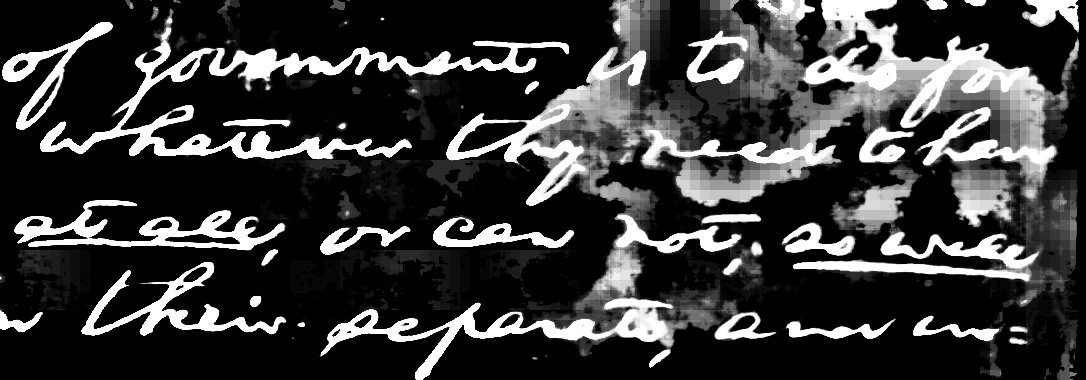

In [10]:
adap_otsu = Otsu_Adap(im2)
Image.fromarray(adap_otsu)

Por último al resultado de aplicar Otsu Adaptativo le podemos aplicar un otsu global con t=250 para suavizar aún más, el resultado de eso es lo siguiente:

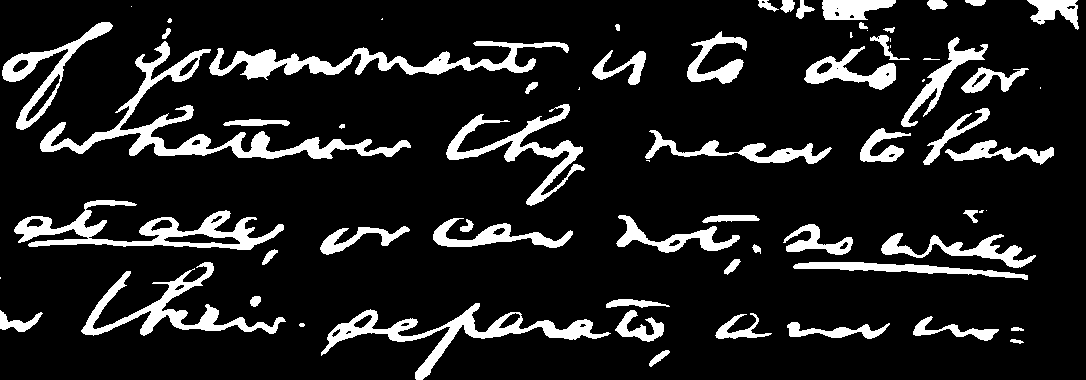

In [11]:
global_otsu =  np.uint8(np.where(adap_otsu<250, 255, 0))
Image.fromarray(255-global_otsu) 


# Componentes conexas

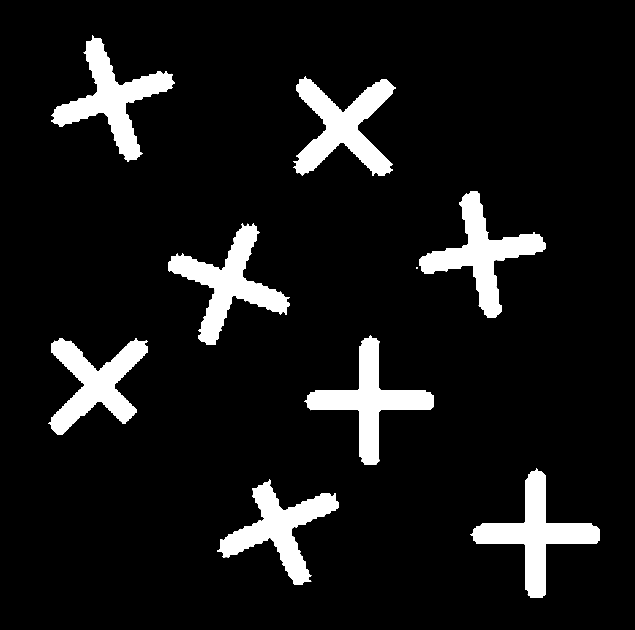

In [16]:
comp = Image.open(imagenes[0])
if comp.mode != "L":
    comp = comp.convert("L")
    
im3 = np.array(comp)
Image.fromarray(im3)

Para el cálculo de componentes conexas haré uso de la librería NetworkX para construir un grafo compuesto por aquellos pixeles no vacios y conectados por 4-connected de la imágen dada. De esta forma una vez construido el grafo y definidas las equivalencias, se sacan sus componentes conexas y se resuelven las equivalencias con el ayuda del grafo.

In [17]:
def get_cc(G, nodes, edges): # recibe un set de tuplas de enteros que representan las aristas entre los nodos(pixeles)
    for n in nodes:
        G.add_node(n)
    for n1,n2 in edges:
        G.add_edge(n1,n2)
  
    return list(nx.connected_components(G)) 

def Label(im):
             
    def get_label(i,j):
        four_connected = [(i,j-1), (i-1, j)] #si fuera 8-conectadas añadir además (i-1,j-1), (i-1, j+1)]
        values = []
        for i, j in four_connected:
            if not(i>=0 and j>=0 and i<im.shape[0] and j<im.shape[1]): continue # si no se da, next iteration
                
            #res inialmente se llena de pixeles de valor backgroud
            if res[i,j] != background: 
                values.append(int(res[i,j]))
        if len(values) == 0: 
            return prev_label + 1
        
        values = tuple(sorted(set((values))))
        ## Añadimos nuevos edges
        for edge_i in values[:-1]:
            for edge_j in values[1:]:
                edges.add((edge_i, edge_j))
        
        return values[0]
            
    b = int(input('Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: '))
    background = 0 if b == 0 else 255
    G = nx.Graph()
    edges = set()
    nodes = set()
    prev_label = 0
    res = np.full((im.shape[0], im.shape[1]), background) 

    # 1: definimos y etiquetamos equivalencias
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j] != background:
                res[i,j] = get_label(i,j) #se saca la etiqueta de la componente correspondiente y se actualiza edges
                
                #Actualizamos la última equivalencia conocida
                if res[i,j] > prev_label:
                    prev_label = res[i,j]
                    
    # 2: resolvemos equivalencias
    for e in edges:
        nodes.update(e)
    connected_components = get_cc(G, nodes, edges)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for index, component in enumerate(connected_components):
                if res[i,j] in component:
                    res[i,j] = index +1
    
    # COLOREAR LAS COMPONENTES
    coloured_res = np.full((res.shape[0], res.shape[1], 3), background) #se puede devolver en positivo o en negativo dependiendo del background
    values = [mcolors.to_rgb(i) for i in mcolors.TABLEAU_COLORS.values()]    
    values = [(int(255*r), int(255*g), int(255*b)) for r,g,b, in values]
    colors = values[0:len(connected_components)]
    for index, color in enumerate(colors):
        connected_comp = index +1
        coloured_res[res == connected_comp,] = color
    
    return np.uint8(coloured_res),np.uint8(res) # devuelvo la versión coloreada y la gris 


In [18]:
labeled_col, labeled_gray = Label(im3)

Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: 0


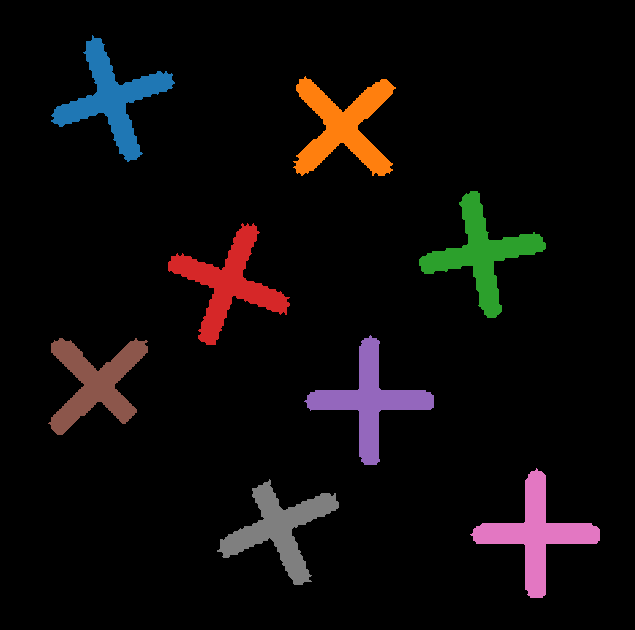

In [19]:
Image.fromarray(labeled_col)